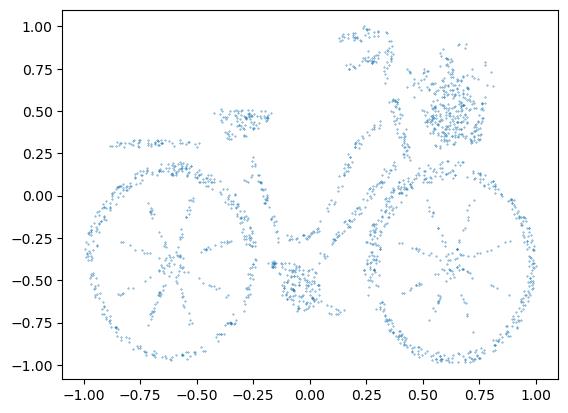

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

with open("bicycle.txt", "r") as file:
    points = []
    for line in file:
        points.append([float(i) for i in line.split()])
points = torch.tensor(points)


sample_indices = np.random.choice(points.shape[0], 2000)
sample_points = points[sample_indices]
fig, ax = plt.subplots()
ax.scatter(sample_points[:, 0], sample_points[:, 1], s=0.1)
fig.savefig("bicycle.png", dpi=300)

In [48]:
class LearnableSinusoidalEmbedding(torch.nn.Module):
    def __init__(self, seq_len=1000, encoding_dim=50, outer_dim=128, denom_base=1000):
        super().__init__()
        self.dim = encoding_dim
        self.seq_len = seq_len
        self.n = denom_base
        self.encodings = torch.zeros(seq_len, encoding_dim)

        for k in range(seq_len):
            for i in np.arange(int(encoding_dim / 2)):
                denominator = denom_base ** (2 * i / encoding_dim)
                self.encodings[k, 2 * i] = np.sin(k / denominator)
                self.encodings[k, 2 * i + 1] = np.cos(k / denominator)

        self.dense0 = torch.nn.Linear(encoding_dim, 128)
        self.relu0 = torch.nn.ReLU()
        self.dense1 = torch.nn.Linear(128, outer_dim)

    def forward(self, x: torch.Tensor):
        assert len(x.shape) == 1
        x = self.encodings[x.long()]
        x = self.dense0(x)
        x = self.relu0(x)
        x = self.dense1(x)
        return x


class ConditionalDenseLayer(torch.nn.Module):
    def __init__(self, in_dim: int, out_dim: int, activation: torch.nn.Module = torch.nn.ReLU()):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.dense = torch.nn.Linear(in_dim, out_dim)
        self.lse = LearnableSinusoidalEmbedding(outer_dim=out_dim)
        self.activation = activation

    def forward(self, x, cond):
        x = self.dense(x)
        cond = self.lse(cond)
        print(x.shape, cond.shape)
        x = x + cond
        x = self.activation(x)
        return x


class DiffussionGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cdl0 = ConditionalDenseLayer(2, 128)
        self.cdl1 = ConditionalDenseLayer(128, 128)
        self.cdl2 = ConditionalDenseLayer(128, 128)
        self.cdl3 = ConditionalDenseLayer(128, 2, activation=torch.nn.Identity())

    def forward(self, x: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        x = self.cdl0(x, cond)
        x = self.cdl1(x, cond)
        x = self.cdl2(x, cond)
        x = self.cdl3(x, cond)
        return x


class Diffusion:
    def __init__(self, points, beta_start, beta_end, timesteps=1000):
        self.points = points
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps

        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = torch.ones_like(self.betas) - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, 0)
        self.alphas_cumprod: torch.Tensor
        self.sqrt_alphas_cumprod: torch.Tensor
        self.one_minus_alphaprods = (
            torch.ones_like(self.alphas_cumprod) - self.alphas_cumprod
        )

        self.dense_0 = torch.nn.Linear(2, 128)
        self.relu_0 = torch.nn.ReLU()
        self.dense_1 = torch.nn.Linear(128, 128)
        self.relu_1 = torch.nn.ReLU()
        self.dense_2 = torch.nn.Linear(128, 128)
        self.relu_2 = torch.nn.ReLU()
        self.dense_3 = torch.nn.Linear(128, 2)

    def sample(self, num_samples: int):
        sample_indices = np.random.choice(self.points.shape[0], num_samples)
        sample_points = self.points[sample_indices]
        return sample_points

    def diffuse_one_point_one_time(
        self, point: torch.Tensor, noise: torch.Tensor, timestep: int
    ):
        return (
            point * self.sqrt_alphas_cumprod[timestep]
            + noise * self.one_minus_alphaprods[timestep]
        )

    def diffuse_one_point(self, point: torch.Tensor, noise: torch.Tensor):
        point = point.unsqueeze(0).repeat(self.timesteps, 1)
        coefs_1 = self.sqrt_alphas_cumprod.unsqueeze(1).repeat(1, 2)
        noise = noise.unsqueeze(0).repeat(self.timesteps, 1)
        coefs_2 = self.one_minus_alphaprods.unsqueeze(1).repeat(1, 2)
        return point * coefs_1 + noise * coefs_2

    def diffuse_points(self, points: torch.Tensor, noises: torch.Tensor):
        points = points.unsqueeze(1).repeat(1, self.timesteps, 1)
        coefs_1 = self.sqrt_alphas_cumprod.reshape(1, self.timesteps, 1).repeat(
            points.shape[0], 1, 2
        )
        noises = noises.unsqueeze(1).repeat(1, self.timesteps, 1)
        coefs_2 = self.one_minus_alphaprods.reshape(1, self.timesteps, 1).repeat(
            points.shape[0], 1, 2
        )
        return points * coefs_1 + noises * coefs_2

    def plot_alfacumprod(self, fname):
        fig, ax = plt.subplots()
        ax.plot(self.alphas_cumprod)
        ax.set_title("Alphas cumprod")
        ax.set_xlabel("timestep")
        ax.set_ylabel("alpha cumprod")
        fig.savefig(fname)
        plt.close(fig)


diffussion = Diffusion(sample_points, 0.0001, 0.02, timesteps=1000)
diffussion.plot_alfacumprod("alfacumprod.png")

model = DiffussionGenerator()

In [ ]:
sample = diffussion.sample(2000)
noise = torch.randn(2000, 2)
results = diffussion.diffuse_points(sample, noise)

for i in range(results.shape[1]):
    print(f"{i}/{results.shape[1]}", end="\r")
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(results[:, i, 0], results[:, i, 1], s=0.1)
    ax.set_title(f"Diffusion of 2000 points over {i} timesteps")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.savefig(f"./diffusion_animation/{i}.png")
    plt.close(fig)

In [1]:
from PIL import Image
import os

images = []
files = os.listdir("./diffusion_animation")
files = sorted(files, key=lambda x: int(x.split(".")[0]))[::10]

for filename in files:
    images.append(Image.open("./diffusion_animation/" + filename))
for filename in files[::-1]:
    images.append(Image.open("./diffusion_animation/" + filename))


images[0].save(
    "./diffusion_animation.gif",
    save_all=True,
    append_images=images[1:],
    duration=100,
    loop=0,
)

In [49]:
model_input = torch.randn(2000, 2)
model_output = model(model_input, torch.randn(2000))
model_output

torch.Size([2000, 128]) torch.Size([2000, 128])
torch.Size([2000, 128]) torch.Size([2000, 128])
torch.Size([2000, 128]) torch.Size([2000, 128])
torch.Size([2000, 2]) torch.Size([2000, 2])


tensor([[-0.0663, -0.2437],
        [-0.0430, -0.2364],
        [-0.0619, -0.2462],
        ...,
        [-0.0355, -0.2286],
        [-0.2506, -0.0440],
        [-0.0557, -0.1729]], grad_fn=<AddBackward0>)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

for i in range(1000):
    print(f"{i}/1000", end="\r")
    optimizer.zero_grad()
    model_output = model(model_input, torch.randn(2000))
    loss = loss_fn(model_output, results[:, -1, :])
    loss.backward()
    optimizer.step()

    